In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from numpy.linalg import svd
import scipy.linalg as la
from scipy.linalg import sqrtm
from numpy.linalg import matrix_power
from scipy.integrate import quad
from scipy.interpolate import interp1d
import copy
X=np.array([[0,1],[1,0]])
Y=np.array([[0,-1j],[1j,0]])
Z=np.array([[1,0],[0,-1]])
Hadamard=np.array([[1,1],[1,-1]])/np.sqrt(2)

In [2]:
def get_psi(n_qubits):
    psi = np.reshape(np.array([np.random.normal() for i in range(2**n_qubits)]) + 1j*np.array([np.random.normal() for i in range(2**n_qubits)]), (2**n_qubits,1))
    psi=psi/(np.sqrt(psi.conjugate().T@psi))
    return psi
def Fidelity(a,b):
    return np.real(np.trace(sqrtm(sqrtm(b)@a@sqrtm(b)))**2)
def matrix_exp(matrix):
    a=np.linalg.eig(matrix)
    return a[1]@np.diag(np.exp(a[0]))@a[1].conjugate().T

In [3]:
psi0=get_psi(1) # random pure initial state

dt=0.1


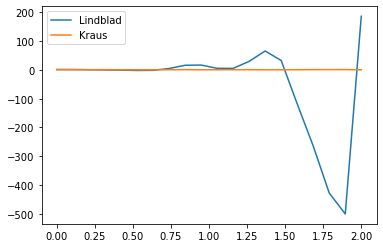

In [4]:
rho0=psi0@psi0.T.conjugate()
T2=10
L1=Z/np.sqrt(T2*2)
t1=0
t2=2

def H(t):
    return np.pi*Z+(5*np.pi/2)*np.cos(5*t)*X

def evol_Lindblad(rho0,dt,t1=t1,t2=t2,L1=L1,H=H):
    rho=np.array([rho0])
    Fidelity_samples=np.array([])
    for i in range(int(t2/dt-t1/dt)):
        rho=np.append(rho,np.array([rho[i]-1j*H(dt*i)@rho[i]*dt+1j*rho[i]@H(dt*i)*dt-0.5*L1.T.conjugate()@L1@rho[i]*dt-0.5*dt*rho[i]@L1.T.conjugate()@L1+L1.conjugate().T@rho[i]@L1*dt]),axis=0)
        Fidelity_samples=np.append(Fidelity_samples,np.array([Fidelity(rho[i],rho0)]))
    plt.plot(np.linspace(t1,t2,int(t2/dt-t1/dt)),Fidelity_samples)
    
def E0(dt,T2=T2):# Kraus operators
    gamma=1-np.exp(-2*dt/T2)
    return np.array([[1,0],[0,np.sqrt(1-gamma)]])

def E1(dt,T2=T2):
    gamma=1-np.exp(-2*dt/T2)
    return np.array([[0,0],[0,np.sqrt(gamma)]])

def evol_op(rho,t,dt): # unitary evolution with effective Hamiltonian
    U=matrix_exp(-1j*H(t)*dt)
    return U@rho@(U.T.conjugate())

def Kraus(rho,t,dt): # Kraus transformation
    return E0(dt)@rho@(E0(dt).T.conjugate())+E1(dt)@rho@(E1(dt).T.conjugate())

def evol_Kraus(rho0,dt,t1=t1,t2=t2):
    rho=np.array([rho0])
    Fidelity_samples=np.array([])
    N=int(t2/dt-t1/dt)
    t=t1
    for i in range(N):
        Fidelity_samples=np.append(Fidelity_samples,np.array([Fidelity(rho[-1],rho0)]))
        rho=np.append(rho,np.array([Kraus(evol_op(rho[-1],t,dt),t,dt)]),axis=0)
        t+=dt
    plt.plot(np.linspace(t1,t2,int(t2/dt-t1/dt)),Fidelity_samples)
    
evol_Lindblad(rho0,0.1)#Linblad equation
evol_Kraus(rho0,0.1)
plt.legend(['Lindblad', 'Kraus'])
print("dt=0.1")

dt=0.01


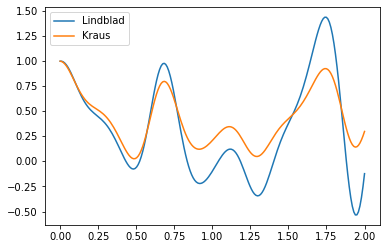

In [5]:
evol_Lindblad(rho0,0.01)
evol_Kraus(rho0,0.01)
plt.legend(['Lindblad', 'Kraus'])
print("dt=0.01")

dt=0.001


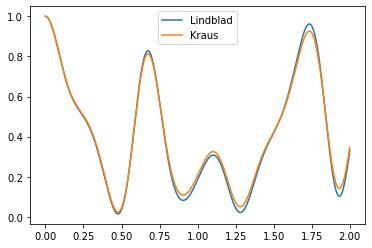

In [6]:
evol_Lindblad(rho0,0.001)
evol_Kraus(rho0,0.001)
plt.legend(['Lindblad', 'Kraus'])
print("dt=0.001")

# generation of random numbers

In [7]:
accuracy=0.99 #This parameter determines how many Fock states is needed to approximate coherent state of light
alpha=1.5
theta=np.pi*3
def factor(n):
    fact = 1
    for i in range(2, n + 1):
        fact *= i
    return fact
def coherent(alpha,ac=accuracy):
    fid=0
    n=0
    while fid<ac:
        psi=np.exp((-np.abs(alpha)**2)/2)*np.array([[(alpha**i)/np.sqrt(factor(i))] for i in range(n+1)])
        psi_check=psi
        psi=psi/np.sqrt(psi.T.conjugate()@psi)
        fid = np.abs(psi.T.conjugate()@psi_check)**2
        n+=1
    return psi
psi=coherent(-1.5)+coherent(1.5)
psi=psi/np.sqrt(psi.T.conjugate()@psi)   
def hermit(x, n):
    if n == 0:
        return 1
    elif n == 1:
        return 2 * x
    else:
        return 2 * x * hermit(x, n - 1) - 2 * (n - 1) * hermit(x, n - 2)        
def hermit_cheb(x, n):
    return (1 / np.sqrt((2 ** n) * factor(n) * np.sqrt(np.pi))) * hermit(x, n) * np.exp(-(x ** 2) / 2)    
def distribution(psi,x,theta=theta):
    return np.abs(np.array([psi[i][0]*hermit_cheb(x,i)*np.exp(1j*i*theta) for i in range(len(psi))]).sum())**2

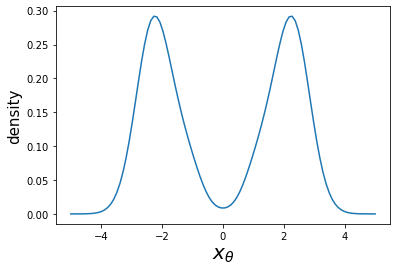

In [8]:
x=np.linspace(-5,5,100)
distibution_function=np.array([distribution(psi,x[i]) for i in range(len(x))])
plt.plot(x,distibution_function)
plt.ylabel("density",fontsize=15)
plt.xlabel(r"$x_\theta$",fontsize=20)
plt.show()

In [9]:
def func_distr(psi, x, theta=theta):
    return quad(lambda x: distribution(psi,x), -100, x)[0]
F=np.array([func_distr(psi,x[i]) for i in range(len(x))])

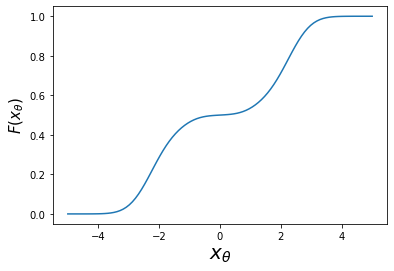

In [10]:
plt.plot(x,F)
plt.ylabel(r"$F(x_\theta)$",fontsize=15)
plt.xlabel(r"$x_\theta$",fontsize=20)
plt.show()

In [11]:
inverse_func = interp1d(F, x, kind='cubic') # метод обратной функции

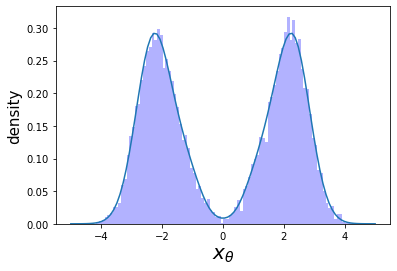

In [12]:
random_samples=np.array([random.random() for i in range(10000)])
inverse_distribution=np.array([inverse_func(random_samples[i]) for i in range(len(random_samples))])
plt.hist(inverse_distribution, bins=100, color='blue', alpha=0.3, density=True)
plt.plot(x,distibution_function)
plt.ylabel("density",fontsize=15)
plt.xlabel(r"$x_\theta$",fontsize=20)
plt.show()

In [13]:
def init_distr(N,dx=0):
    if N==1:
        a=random.random()
        if a>0.5:
            return dx+np.random.randn()+2
        else:
            return dx+np.random.randn()-2
    x=np.array([])
    for i in range(N):
        a=random.random()
        if a>0.5:
            x=np.append(x,dx+np.random.randn()+2)
        else:
            x=np.append(x,dx+np.random.randn()-2)
    return x
    

In [14]:
aver_x_2 = quad(lambda x: (x ** 2) * distribution(psi=psi,x=x,theta=theta), -100, 100)[0]
aver_x = quad(lambda x: x * distribution(psi=psi,x=x,theta=theta), -100, 100)[0]
sigma = np.sqrt(aver_x_2 - aver_x ** 2)
d = 5 * sigma
k=2000
iterations=50

In [15]:
#Метод Метрополиса
x_t=init_distr(k)
for m in range(iterations):
    for i in range(k):
        x_proposal=np.random.randn(1)*0.5+x_t[i]
        acceptance=min(1,distribution(psi=psi,x=x_proposal,theta=theta)/distribution(psi=psi,x=x_t[i],theta=theta))
        u=random.random()
        if acceptance>u:
            x_t[i]=x_proposal
    

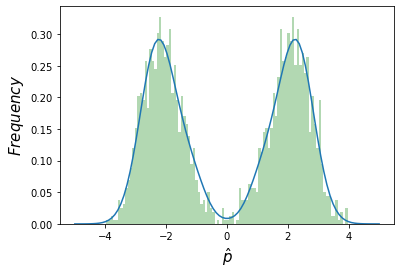

In [16]:
plt.hist(x_t, bins=100, color='green', alpha=0.3, density=True)
plt.plot(x,distibution_function)
plt.xlabel(r'$\hat{p}$', fontsize=15)
plt.ylabel(r'$Frequency$', fontsize=15)
plt.show()

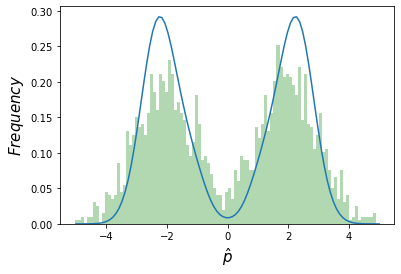

In [17]:
#initial destribution(i used it for fast convergance)
plt.hist(init_distr(k), bins=100, color='green', alpha=0.3, density=True)
plt.plot(x,distibution_function)
plt.xlabel(r'$\hat{p}$', fontsize=15)
plt.ylabel(r'$Frequency$', fontsize=15)
plt.show()